# Удаление случайного и "соль-перец" шума с помощью фильтров низких и высоких частот
В данной работе демонстрируется добавление случайного шума и шума типа "соль-перец", а также удаление их с изображения с фильтра низких и высоких частот.

Для начала импортируем все необходимые пакеты для работы, а также реализованную ранее функцию добавления шума.

In [1]:
import numpy as np
%matplotlib inline
import reader
import grapher

from analysis.statistics import autocorrelation
from analysis import FT
from analysis.preprocessing import add_noise, LPF, HPF
from analysis.impulse_response import process

Прочтем и отобразим исходное изображение и информацию о нем. Нормализовывать изображение не будем для корректного отображения фона.

Image shape:  (300, 400)


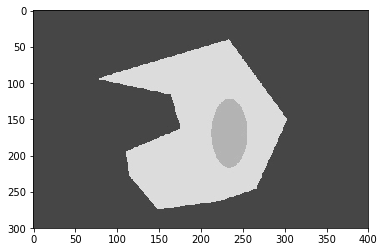

In [2]:
col_num, row_num, depth, image_data = reader.jpg_reader("data/MODEL.jpg", channels=1)
print('Image shape: ', image_data.shape)
grapher.set_image(image_data, cmap="gray", normalize=False)

Далее добавим случайный шум и шум типа "соль-перец", и отобразим оба изображения.

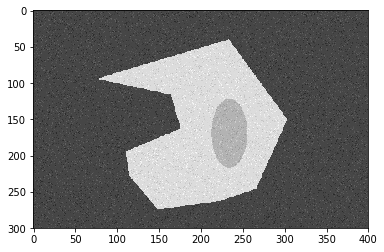

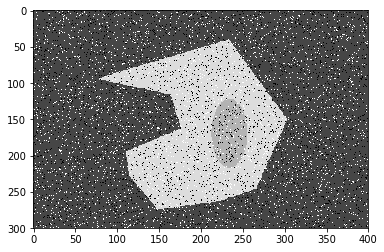

In [3]:
randnoise_data = add_noise(image_data, "random", sparsity=0.25)
spnoise_data = add_noise(image_data, "s&p", sparsity=0.1)

grapher.set_image(randnoise_data, cmap="gray", normalize=False)
grapher.set_image(spnoise_data, cmap="gray", normalize=False)

Для вычисления необходимых характеристик фильтров посчитаем автокорреляцию и возьмем преобразование Фурье от обоих картинок, чтобы вычислить частоты шума.

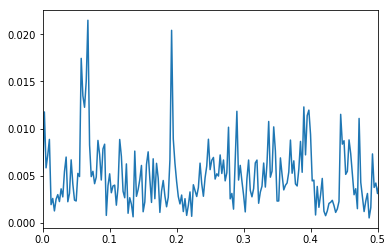

In [4]:
ac = [autocorrelation(randnoise_data[0], i) for i in range(len(randnoise_data[0]))]
res = FT.fourier_transform(ac, 1)
grapher.set_subplot(1,
                    y_arr=res.frequencies,
                    x_arr=[i * res.deltaF for i in range(len(res.frequencies))],
                    xmin=0, xmax=res.borderF,
                    subplot_x_number=1, subplot_y_number=1)

Аналогично от второй.

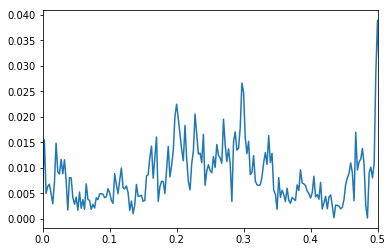

In [5]:
ac = [autocorrelation(spnoise_data[0], i) for i in range(len(spnoise_data[0]))]
res = FT.fourier_transform(ac, 1)
grapher.set_subplot(1,
                    y_arr=res.frequencies,
                    x_arr=[i * res.deltaF for i in range(len(res.frequencies))],
                    xmin=0, xmax=res.borderF,
                    subplot_x_number=1, subplot_y_number=1)

Как можно заметить, на обоих картинках значимые вариации начинаются примерно с частоты 0.1Гц, следовательно, для этой частоты и реализуем фильтр.

Создадим и применим фильтр низких частот для случайного шума.

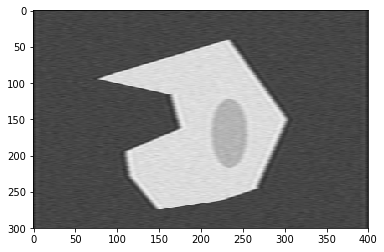

In [6]:
m = 32
LPFilter = LPF(0.1, 1, m)
lpf_randnoise_data = np.empty_like(randnoise_data)
for i in range(len(randnoise_data)):
    lpf_randnoise_data[i] = process(randnoise_data[i], LPFilter)[m:-m - 1]
grapher.set_image(lpf_randnoise_data, cmap="gray", normalize=False)

Как можно заметить, фильтр размазал шум по изображению, снизив его наличие, но и "размазав" саму фотографию.  
Применим аналогичный фильтр для изображения с шумом "соль-перец".

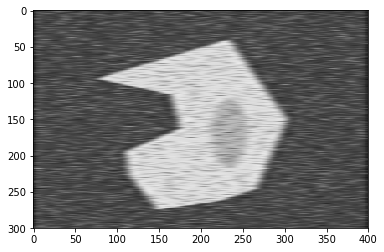

In [7]:
m = 32
LPFilter = LPF(0.05, 1, m)
lpf_spnoise_data = np.empty_like(spnoise_data)
for i in range(len(spnoise_data)):
    lpf_spnoise_data[i] = process(spnoise_data[i], LPFilter)[m:-m - 1]
grapher.set_image(lpf_spnoise_data, cmap="gray", normalize=False)

Можно заметить, что с шумом типа "соль-перец" фильтр справляется гораздо хуже и лишь смазывает изображение, не оказывая никакого влияния на шум.  
Далее аналогичным образом можно применить фильтр высоких частот и вычесть получившееся изображение из исходного.

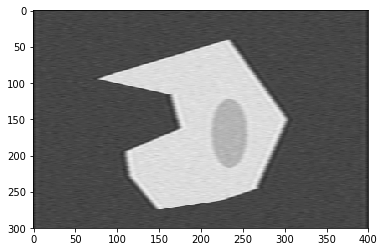

In [8]:
m = 32
HPFilter = HPF(0.1, 1, m)
hpf_randnoise_data = np.empty_like(randnoise_data)
for i in range(len(randnoise_data)):
    hpf_randnoise_data[i] = process(randnoise_data[i], HPFilter)[m:-m - 1]
grapher.set_image(randnoise_data - hpf_randnoise_data, cmap="gray", normalize=False)

На приведенном изображениее видно, что такой подход дает неплохой результат при удалении случайного шума.  
Реализуем аналогичный для шума "соль-перец".

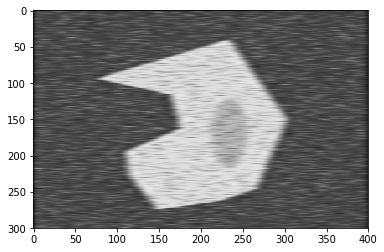

In [9]:
m = 32
HPFilter = HPF(0.05, 1, m)
hpf_spnoise_data = np.empty_like(spnoise_data)
for i in range(len(spnoise_data)):
    hpf_spnoise_data[i] = process(spnoise_data[i], HPFilter)[m:-m - 1]
grapher.set_image(spnoise_data - hpf_spnoise_data, cmap="gray", normalize=False)

Для шума "соль-перец" данный подход неприменим, т.к., как и в случае с фильтром низких частот, лишь смазывает изображение, но не позволяет убрать шумы.